This notebook requires the "./data/mock_datacube.fits" file. The notebook "simulate_mock_datacube.ipynb" needs to be run to create that datacube.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ppxf.sps_util as sps_util
from astropy.io import fits

import squirrel
from squirrel import giant
from squirrel.data import Datacube
from squirrel.template import Template

squirrel.__version__

'0.0.0'

In [2]:
data, header = fits.getdata("./data/mock_datacube.fits", header=True)
noise = fits.getdata("./data/mock_datacube.fits", ext=1)

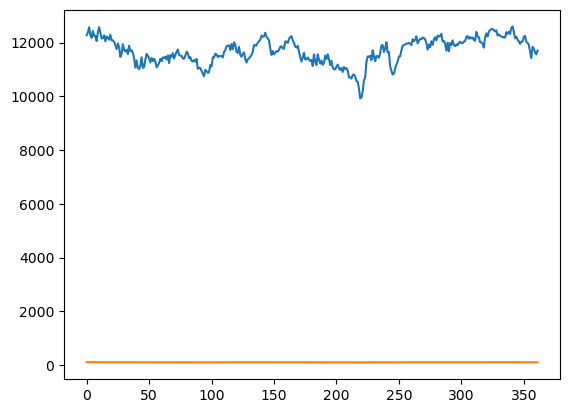

In [3]:
plt.plot(data[:, 17, 17])
plt.plot(noise[:, 17, 17])

In [4]:
data.shape

(362, 35, 35)

In [5]:
wavelengths = (
    header["CRVAL3"] + header["CDELT3"] * (1 + np.arange(header["NAXIS3"]))
) * 1e4

z_lens = 0.3
z_source = 1.0

fwhm = (wavelengths[1] - wavelengths[0]) * 2

center_pixel_x = 17
center_pixel_y = 17

coordinate_transform_matrix = (
    np.array([[header["PC1_1"], header["PC1_2"]], [header["PC2_1"], header["PC2_2"]]])
    * header["CDELT1"]
    * 3600
)

datacube = Datacube(
    wavelengths=wavelengths,
    flux=data,
    wavelength_unit="AA",
    flux_unit=header["BUNIT"],
    noise=noise,
    fwhm=fwhm,
    z_lens=z_lens,
    z_source=z_source,
    center_pixel_x=center_pixel_x,
    center_pixel_y=center_pixel_y,
    coordinate_transform_matrix=coordinate_transform_matrix,
)

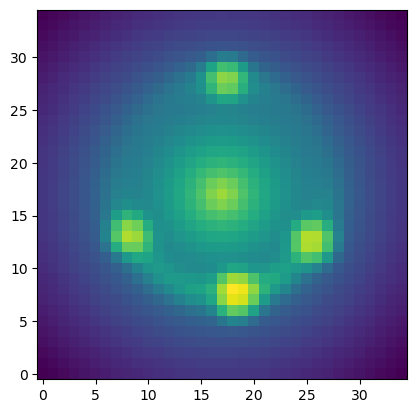

In [6]:
plt.imshow(
    np.sqrt(datacube.x_coordinates**2 + datacube.y_coordinates**2),
    origin="lower",
)
plt.imshow(np.log10(np.nansum(datacube.flux, axis=0)), origin="lower")

In [7]:
datacube.reset()
datacube.deredshift(target_frame="lens")
datacube.clip(wavelength_min=8200, wavelength_max=8950)

datacube.flux.shape

(153, 35, 35)

In [8]:
datacube.spectra_modifications, datacube.wavelengths_frame

(['clipped'], 'lens frame')

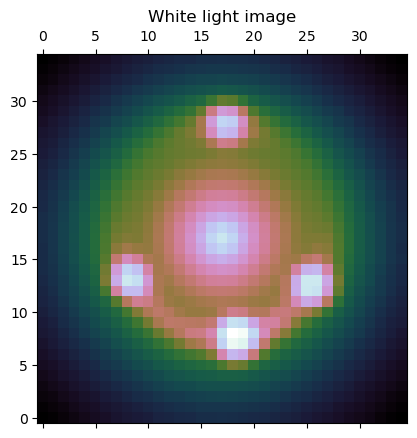

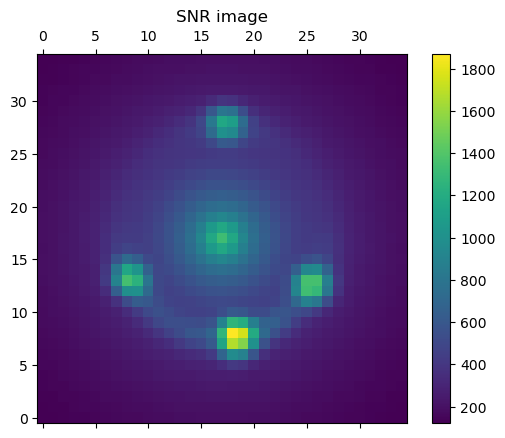

In [9]:
ax = plt.subplot(111)

ax.matshow(
    np.log10(np.nansum(datacube.flux, axis=0)),
    origin="lower",
    aspect="equal",
    cmap="cubehelix",
)
ax.set_title("White light image")
plt.show()

ax = plt.subplot(111)
im = ax.matshow(
    np.nansum(datacube.flux, axis=0) / np.sqrt(np.nansum(datacube.noise**2, axis=0)),
    origin="lower",
    aspect="equal",
    cmap="viridis",
)
ax.set_title("SNR image")
plt.colorbar(im)
plt.show()

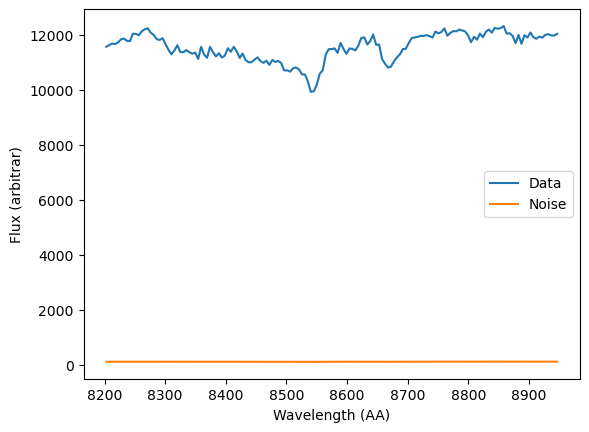

In [10]:
ax = plt.subplot(111)

ax.plot(
    datacube.wavelengths,
    datacube.flux[:, 17, 17],
    label="Data",
)

ax.plot(datacube.wavelengths, datacube.noise[:, 17, 17], label="Noise")
ax.set_xlabel(f"Wavelength ({datacube.wavelength_unit})")
ax.set_ylabel(f"Flux ({datacube.flux_unit})")
ax.legend()

## do Voronoi binning

Bin-accretion...
1  /  40
2  /  40
3  /  40
4  /  40
5  /  40
6  /  40
7  /  40
8  /  40
9  /  40
10  /  40
11  /  40
12  /  40
13  /  40
14  /  40
15  /  40
16  /  40
17  /  40
18  /  40
19  /  40
20  /  40
21  /  40
22  /  40
23  /  40
24  /  40
25  /  40
26  /  40
27  /  40
28  /  40
29  /  40
30  /  40
31  /  40
32  /  40
33  /  40
34  /  40
35  /  40
36  /  40
37  /  40
38  /  40
39  /  40
40  /  40
39  initial bins.
Reassign bad bins...
36  good bins.
Modified Lloyd algorithm...
Iter:    1  Diff: 1.799
Iter:    2  Diff: 0.6949
Iter:    3  Diff: 0.5283
Iter:    4  Diff: 0
3  iterations.
Unbinned pixels:  0  /  317
Fractional S/N scatter (%): 13.071420631596828
Elapsed time accretion: 0.01 seconds
Elapsed time optimization: 0.00 seconds


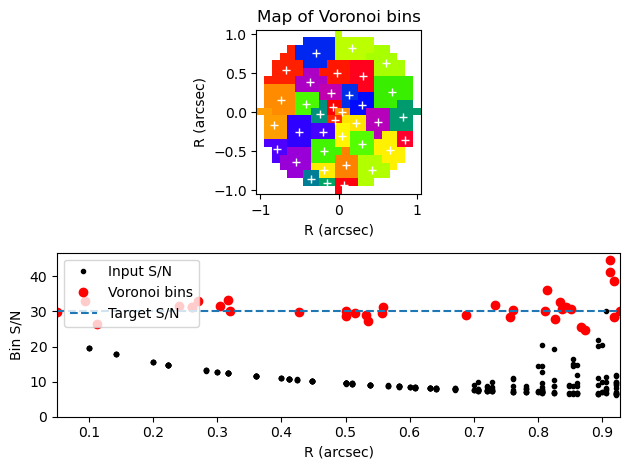

In [11]:
voronoi_binned_spectra = giant.Shoulder.voronoi_bin(
    datacube,
    target_snr=30,
    min_wavelength_for_snr=8700,
    max_wavelength_for_snr=8800,
    max_radius=1.0,
    min_snr_per_spaxel=1.0,
    plot=True,
    quiet=False,
)

In [12]:
voronoi_binned_spectra.flux.shape

(153, 36)

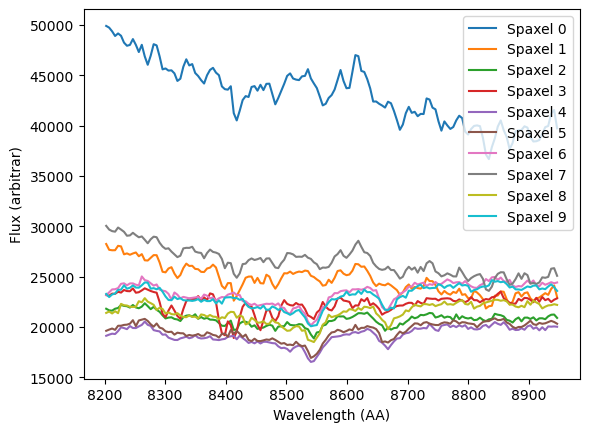

In [13]:
for i in range(10):
    plt.plot(
        voronoi_binned_spectra.wavelengths,
        voronoi_binned_spectra.flux[:, i],
        label=f"Spaxel {i}",
    )
plt.xlabel(f"Wavelength ({voronoi_binned_spectra.wavelength_unit})")
plt.ylabel(f"Flux ({voronoi_binned_spectra.flux_unit})")
plt.legend()
plt.show()

## create stellar templates

In [15]:
giant.Shoulder.log_rebin(voronoi_binned_spectra)

In [16]:
voronoi_binned_spectra.spectra_modifications, datacube.wavelengths_frame

(['log_rebinned'], 'lens frame')

In [17]:
voronoi_binned_spectra.flux.shape, voronoi_binned_spectra.wavelengths.shape

((153, 36), (153,))

In [18]:
wavelength_range_templates = (
    voronoi_binned_spectra.wavelengths[0] / 1.2,
    voronoi_binned_spectra.wavelengths[-1] * 1.2,
)

sps_name = "emiles"

template_filename = (
    f"/Users/ajshajib/research/stellar_template_libraries/spectra_{sps_name}_9.0.npz"
)
velocity_scale_ratio = 2

# template library will be sampled at data resolution times the velscale_ratio in the given wavelength range
sps = sps_util.sps_lib(
    template_filename,
    voronoi_binned_spectra.velocity_scale / velocity_scale_ratio,  # resolution
    fwhm,
    wave_range=wavelength_range_templates,
)

template_fluxes = sps.templates.reshape(sps.templates.shape[0], -1)
templates_wavelengths = sps.lam_temp

template = Template(
    templates_wavelengths, template_fluxes, wavelength_unit="AA", fwhm=fwhm
)

print(template.flux.shape)

(1581, 150)


In [19]:
ppxf_fit = giant.Shoulder.stand_on(
    voronoi_binned_spectra, template, degree=4, spectra_indices=30
)

 Best Fit:       Vel     sigma
 comp.  0:       140       393
chi2/DOF: 2.411; DOF: 151; degree = 4; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/150


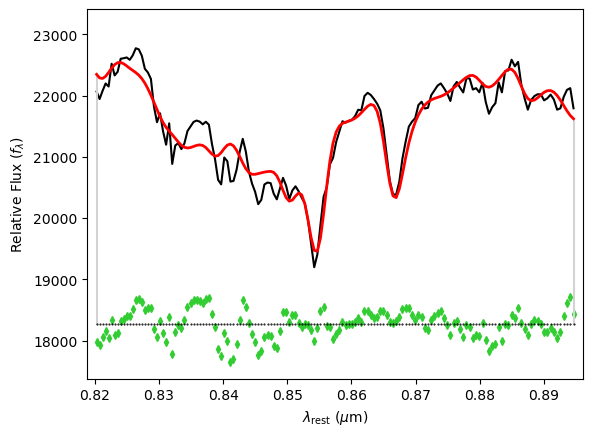

In [20]:
ppxf_fit.plot()